# 基于Simple-baseline-pose-estimation的图像3D姿态估计

## 1.2d检测器

### 1.1 加载模型

In [17]:
%matplotlib inline
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord
import time
import matplotlib.pyplot as plt
import os
import time
import torch
import cv2
import sys
sys.path.append('../../')

detector_name = ['yolo3_mobilenet1.0_coco', 'yolo3_darknet53_coco']
posenet_name = ['simple_pose_resnet18_v1b', 'simple_pose_resnet101_v1b']
detector = model_zoo.get_model(detector_name[1], pretrained=True)
pose_net = model_zoo.get_model(posenet_name[1], pretrained=True)

# reset the detector to only detect human
detector.reset_class(['person'], reuse_weights=['person'])

### 1.2 检测关节点并显示

Shape of pre-processed image: (1, 3, 540, 360)
detector cost time: 0.04
type(pre_coords): <class 'mxnet.ndarray.ndarray.NDArray'>, shape(pre_coords): (1, 17, 2)
total elapsed time: 0.61


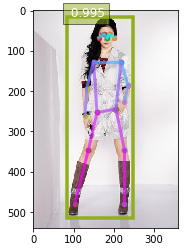

In [18]:
im_fname = 'images/liuyifei1.jpg'

# 1.预处理输入图像和检测人体
x, img = data.transforms.presets.yolo.load_test(im_fname, short=360)
print("Shape of pre-processed image:", x.shape)

start = time.time()

# detect persons and bbox
class_IDs, scores, bounding_boxes = detector(x)

print("detector cost time: {:.2f}".format(time.time() - start))

# 2.预处理检测器的输出张量作为alpha_pose的输入
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxes)

# 4.预测关节点
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)
print("type(pre_coords): {}, shape(pre_coords): {}".format(type(pred_coords), pred_coords.shape))
# print("pred_coords: {}".format(pred_coords))

print("total elapsed time: {:.2f}".format(time.time() - start))

# 5.显示2d姿态
ax = utils.viz.plot_keypoints(img, pred_coords, confidence, class_IDs, bounding_boxes, scores, box_thresh=0.5,
                              keypoint_thresh=0.2)

plt.show()


### 1.3 坐标标准化

In [19]:
def normalize_screen_coordinates(X, w, h): 
    assert X.shape[-1] == 2
    
    # 将 x 坐标 从[0, w] 映射到 [-1, 1], 同时保留宽高比
    return X/w*2 - [1, h/w]

kps = normalize_screen_coordinates(pred_coords[0].asnumpy(), w=img.shape[1], h=img.shape[0])
print('kps.type: {}, kps.shape: {}'.format(type(kps), kps.shape))

kps.type: <class 'numpy.ndarray'>, kps.shape: (17, 2)


## 2.3d姿势预测

### 2.1 加载模型

In [20]:
from common.model import *

def get_pose3d_predictor(ckpt_dir, ckpt_name, filter_widths, causal=False):
    ckpt_path = os.path.join(ckpt_dir, ckpt_name)
    print('Loading checkpoint', ckpt_path)
    checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
    print('This model was trained for {} epochs'.format(checkpoint['epoch']))
    
    pose3d_predictor = TemporalModel(17, 2 ,17, filter_widths=filter_widths, causal=causal)
    receptive_field = pose3d_predictor.receptive_field()
    print('INFO: Receptive field: {} frames'.format(receptive_field))
    pose3d_predictor.load_state_dict(checkpoint['model_pos'])
    
    if torch.cuda.is_available():
        pose3d_predictor = pose3d_predictor.cuda()
    
    return pose3d_predictor


ckpt_dir = '../../checkpoint/detectron_pt_coco'
ckpt_name = 'arc_1_epoch_40.bin'
filter_widths = [1,1,1]
pose3d_predictor = get_pose3d_predictor(ckpt_dir, ckpt_name, filter_widths)
_ = pose3d_predictor.eval()

Loading checkpoint ../../checkpoint/detectron_pt_coco/arc_1_epoch_40.bin
This model was trained for 40 epochs
INFO: Receptive field: 1 frames


### 2.2 2d keypoints生成器

In [21]:
from common.camera import *
from common.generators import UnchunkedGenerator

receptive_field = pose3d_predictor.receptive_field()
pad = (receptive_field - 1) // 2  # Padding on each side
causal_shift = 0

kps = torch.from_numpy(kps).unsqueeze(0).numpy()
print('kps.shape: {}'.format(kps.shape))
# 创建生成器作为3d预测器的输入
generator = UnchunkedGenerator(None, None, [kps], pad=pad, causal_shift=causal_shift, augment=False)

kps.shape: (1, 17, 2)


### 2.3 画图函数

In [22]:
from matplotlib.animation import FuncAnimation, writers
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# 画图
def render_image(keypoints, pos_3d, skeleton, azim, input_video_frame=None):
    fig = plt.figure(figsize=(12, 6), dpi=100)
    canvas = FigureCanvas(fig)
    # 输入图像
    ax_in = fig.add_subplot(1, 2, 1)
    ax_in.get_xaxis().set_visible(False)
    ax_in.get_yaxis().set_visible(False)
    ax_in.set_axis_off()
    ax_in.set_title('Input')
    ax_in.imshow(input_video_frame, aspect='equal')
    
    # 3D
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.view_init(elev=15., azim=azim)
    # set 长度范围
    radius = 2
    ax.set_xlim3d([-radius / 2, radius / 2])
    ax.set_zlim3d([0, 2])
    ax.set_ylim3d([-radius / 2, radius / 2])
    ax.set_aspect('equal')
    # 坐标轴刻度
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.dist = 7.5

    # array([-1,  0,  1,  2,  0,  4,  5,  0,  7,  8,  9,  8, 11, 12,  8, 14, 15])
    parents = skeleton.parents()

    pos = pos_3d['Reconstruction'][-1]
    for j, j_parent in enumerate(parents):
        if j_parent == -1:
            continue

        if len(parents) == keypoints.shape[1]:
            color_pink = 'pink'
            if j == 1 or j == 2:
                color_pink = 'black'

        col = 'red' if j in skeleton.joints_right() else 'black'
        # 画图3D
        ax.plot([pos[j, 0], pos[j_parent, 0]],
                [pos[j, 1], pos[j_parent, 1]],
                [pos[j, 2], pos[j_parent, 2]], zdir='z', c=col)
    
    width, height = fig.get_size_inches() * fig.get_dpi()
    canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
#     plt.close()
    
    return image

### 3d姿势估计和显示

Total elapsed time: 1.33 seconds


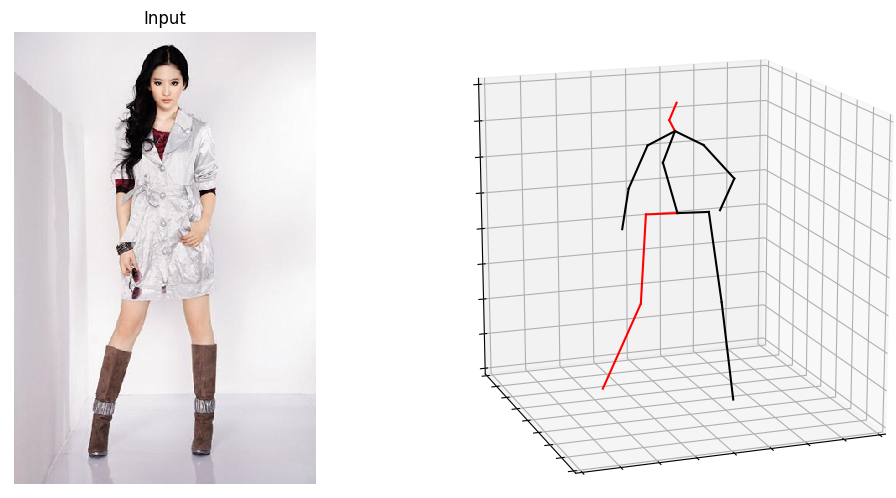

In [23]:
class Skeleton:
    def parents(self):
        return np.array([-1, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15])

    def joints_right(self):
        return [1, 2, 3, 9, 10]

# 预测3d坐标
def predict_3d_pos(test_generator, predictor):
    with torch.no_grad():
        predictor.eval()
        N = 0
        for _, batch, batch_2d in test_generator.next_epoch():
            inputs_2d = torch.from_numpy(batch_2d.astype('float32'))
            if torch.cuda.is_available():
                inputs_2d = inputs_2d.cuda()

            # Positional model
            predicted_3d_pos = predictor(inputs_2d)
            return predicted_3d_pos.squeeze(0).cpu().numpy()

# start = time.time()

prediction = predict_3d_pos(generator, pose3d_predictor)
rot = np.array([0.14070565, -0.15007018, -0.7552408, 0.62232804], dtype=np.float32)
prediction = camera_to_world(prediction, R=rot, t=0)

# We don't have the trajectory, but at least we can rebase the height
prediction[:, :, 2] -= np.min(prediction[:, :, 2])
pos_3d = {'Reconstruction': prediction}
input_keypoints = image_coordinates(kps[..., :2], w=img.shape[1], h=img.shape[0])

# 渲染图像
result_image = render_image(input_keypoints, pos_3d=pos_3d, skeleton=Skeleton(), azim=np.array(70., dtype=np.float32),  input_video_frame=img)
_ = cv2.imwrite('result.jpg', cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))

elaspsed = time.time() - start
print("Total elapsed time: {:.2f} seconds".format(elaspsed)) 